### Question 2: Are women more likely to complete secondary education in some countries than others? In the coming years, what percentage of women overall and by country, do we expect to enroll in secondary education? What factors indicate whether or not a women completes secondary education?

### Import packages and data

In [139]:
#import packages

# general
import numpy as np
import pandas as pd
import time

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# visualization
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import xgboost as xgb
from xgboost import XGBRegressor

In [140]:
#load in the dataset
df = pd.read_csv('country_index.csv')
df.set_index(['Country Name', 'Country Code'], inplace=True)
df.head()

Year  \
Country Name Country Code         
Albania      ALB           -1.0   
             ALB           -0.7   
             ALB            0.1   
             ALB            0.5   
             ALB            0.6   

                           A woman can be head of household in the same way as a man (1=yes; 0=no)  \
Country Name Country Code                                                                            
Albania      ALB                                                         1.0                         
             ALB                                                         1.0                         
             ALB                                                         1.0                         
             ALB                                                         1.0                         
             ALB                                                         1.0                         

                           A woman can choose where to live in the same way as a man (1=yes; 0=no)  \
Country Name Country Code                                                                            
Albania      ALB                                                         1.0                         
             ALB                                                         1.0                         
             ALB                                                         1.0                         
             ALB                                                         1.0                         
             ALB                                                         1.0                         

                           A woman can get a job in the same way as a man (1=yes; 0=no)  \
Country Name Country Code                                                                 
Albania      ALB                                                         1.0              
             ALB                                                         1.0              
             ALB                                                         1.0              
             ALB                                                         1.0              
             ALB                                                         1.0              

                           A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)  \
Country Name Country Code                                                                                    
Albania      ALB                                                         1.0                                 
             ALB                                                         1.0                                 
             ALB                                                         1.0                                 
             ALB                                                         1.0                                 
             ALB                                                         1.0                                 

                           A woman can open a bank account in the same way as a man (1=yes; 0=no)  \
Country Name Country Code                                                                           
Albania      ALB                                                         1.0                        
             ALB                                                         1.0                        
             ALB                                                         1.0                        
             ALB                                                         1.0                        
             ALB                                                         1.0                        

                           A woman can register a business in the same way as a man (1=yes; 0=no)  \
Country Name Country Code                                                                           
Albania      ALB                

In [141]:
# #remove the country columns so that we can focus on more important predictors

# columns_to_remove = set()
# prev_prefix = 'Country'

# for col in df.columns:
#     prefix = col.split('_')[0]
    
#     if prefix == prev_prefix:
#         columns_to_remove.add(col)
    
#     prev_prefix = prefix

# df = df.drop(columns=columns_to_remove)
# df = df.drop(columns=['Country Name_Algeria', 'Unnamed: 0'])
# df

### Prepare the data for the models

In [142]:
#create X and y dataframes
X = df.drop(columns='School enrollment, secondary, female (% gross)')
y = df[['School enrollment, secondary, female (% gross)']]

In [143]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
y_test

,,"School enrollment, secondary, female (% gross)"
Country Name,Country Code,
Guyana,GUY,0.004843
Cyprus,CYP,0.115674
Mongolia,MNG,0.000000
Namibia,NAM,0.000000
Mexico,MEX,-1.464595
...,...,...
Australia,AUS,0.000000
Seychelles,SYC,-1.331799
"Korea, Rep.",KOR,0.008743


#### Feature engineering

In [144]:
#initialize sfs, use linear regression as the baseline model for this question
sfs = SequentialFeatureSelector(estimator = LinearRegression(),
                                n_features_to_select = "auto",
                                direction = 'forward',
                                scoring = 'neg_mean_squared_error',
                                cv = 10)

#fit the data to sfs
sfs = sfs.fit(X_train, y_train)

#retrieve the and print the names of the selected features
feature_names = np.array(df.columns.difference(['School enrollment, secondary, female (% gross)']))
selected_feature_names = feature_names[sfs.get_support()].tolist()
print("Selected features:", selected_feature_names)

# transform X_train and X_test to include only the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# display the shape of transformed X_train_selected and X_test_selected
print("Transformed X_train shape:", X_train_selected.shape)
print("Transformed X_test shape:", X_test_selected.shape)

Selected features: ['A woman can get a job in the same way as a man (1=yes; 0=no)', 'A woman can open a bank account in the same way as a man (1=yes; 0=no)', 'A woman can register a business in the same way as a man (1=yes; 0=no)', 'A woman can travel outside her home in the same way as a man (1=yes; 0=no)', 'A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no)', 'A woman has the same rights to remarry as a man (1=yes; 0=no)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Age dependency ratio (% of working-age population)', 'Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no)', 'Dismissal of pregnant workers is prohibited (1=yes; 0=no)', 'GDP per capita (Current US$)', 'Inflation, consumer prices (annual %)', 'Length of paid parental leave for father (calendar days)', 'Life expectancy at age 60, female (years)', 'Paid leave is available to fathers (1=yes; 0=no)', 'Population ages 65 and above, fem

### Function for the Models 

In [145]:
def question2(model_type, X_train, y_train):

    # Step 1: Initialize a model object
    if model_type == 'Linear Regression':
      model = LinearRegression()
    elif model_type == 'Ridge':
      model = Ridge()
    elif model_type == 'Random Forest':
      model = RandomForestRegressor()
    elif model_type== 'XGBoost':
      model = XGBRegressor()
    else:
      print('Please specify the model type')

    # Step 2: Train the model
    model.fit(X_train, y_train)

    # Step 3: Make predictions
    y_pred_train = model.predict(X_train)

    # Step 4: Evaluate the model performance

    ## MSE
    #evaluate the model using MSE and R squared
    mse_train = -np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    r_sq_train = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring='r2'))

    #print the MSE and R_squared
    print('MSE (Train): ', round(mse_train, 3))
    print('R-Squared (Train): ', round(r_sq_train, 3))

    return mse_train, r_sq_train

In [146]:
def question2nocv(model_type, X_train, y_train, X_test, y_test):

    # Step 1: Initialize a model object
    if model_type == 'Linear Regression':
      model = LinearRegression()
    elif model_type == 'Ridge':
      model = Ridge()
    elif model_type == 'Lasso':
      model = Lasso()
    elif model_type == 'Random Forest':
      model = RandomForestRegressor()
    elif model_type == 'Gradient Boosting':
      model = GradientBoostingRegressor()
    elif model_type== 'XGBoost':
      model = XGBRegressor()
    else:
      print('Please specify the model type')

    # Step 2: Train the model
    model.fit(X_train, y_train)

    # Step 3: Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Step 4: Evaluate the model performance

    ## MSE
    #evaluate the model using MSE and R squared
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_test = mean_squared_error(y_test,y_pred_test)
    r_sq_train = model.score(X_train, y_train)
    r_sq_test = model.score(X_test, y_test)

    #print the MSE and R_squared
    print('MSE (Train): ', round(mse_train, 3))
    print('MSE (Test): ', round(mse_test, 3))
    print('R-Squared (Train): ', round(r_sq_train, 3))
    print('R-Squared (Test): ', round(r_sq_test, 3))

    return mse_train, mse_test, r_sq_train, r_sq_test

### Model #1: Linear Regression

In [147]:
#running the model
print('Linear Regression:')
mse_train_lr, r_sq_train_lr = question2('Linear Regression', X_train, y_train)
mse_test_lr, r_sq_test_lr = question2('Linear Regression', X_test, y_test)
print('\n')
mse_train_lr, r_sq_train_lr, mse_test_lr, r_sq_test_lr = question2nocv('Linear Regression', X_train, y_train, X_test, y_test)


Linear Regression:


MSE (Train):  0.687
R-Squared (Train):  0.632
MSE (Train):  1.677
R-Squared (Train):  0.007


MSE (Train):  0.564
MSE (Test):  0.788
R-Squared (Train):  0.723
R-Squared (Test):  0.565


#### Hypertuning

We will not be hypertuning the basic linear regression model because there are not parameters to tune.

### Model #2: Ridge Model

For the rest of the models, I used the regular X_train data, not the feature selected. These models do not need to use feature selection.

In [148]:
#running the ridge model
print('Ridge Model:')
mse_train_ridge, r_sq_train_ridge = question2('Ridge', X_train, y_train)

Ridge Model:
MSE (Train):  0.682
R-Squared (Train):  0.635


#### Hypertuning

In [149]:
# Generate a random list of regularization parameters (alphas)
alphas = np.logspace(-2, 8, 100)

# Create a list where you will store the information
model_ridge_coefficients = []
mse_train_ridge_list = []
r2_train_ridge_list = []

# Try each set of alphas in your Ridge model
for a in alphas:
    #Pick the model type by initializing a model object and set the alpha from the list as a model parameter
    model_ridge = Ridge()
    model_ridge.set_params(alpha=a)

    #Train the model by passing some data
    model_ridge.fit(X_train, y_train)

    #Evaluate the model performance
    mse_train_ridge = -np.mean(cross_val_score(model_ridge, X_test, y_test, cv=10, scoring='neg_mean_squared_error'))
    r2_train_ridge = np.mean(cross_val_score(model_ridge, X_test, y_test, cv=10, scoring='r2'))

    # Append all results to the lists so we could look at them and also plot them
    model_ridge_coefficients.append(model_ridge.coef_)
    mse_train_ridge_list.append(mse_train_ridge)
    r2_train_ridge_list.append(r2_train_ridge)

In [150]:
#Find and print the best alpha

# Find the lowest value of MSE train value
min_mse_train_ridge = np.min(mse_train_ridge_list)
print("Min MSE Train: ", min_mse_train_ridge)

# Find the index of the lowest MSE train value
min_mse_train_ridge_index = np.argmin(mse_train_ridge_list)
print("Index of Min MSE train: ", min_mse_train_ridge_index)

# Call alphas with the index of the lowest MSE train value
best_alpha = alphas[min_mse_train_ridge_index]
print("Best alpha: ", best_alpha)

Min MSE Train:  1.1617360619735908
Index of Min MSE train:  32
Best alpha:  17.073526474706906


#### Run the model using the best alpha

In [151]:
# Pick the model type by initializing a model object and set the alpha to the best alpha
model_ridge_best_alpha = Ridge()
model_ridge_best_alpha.set_params(alpha=best_alpha)

# Train the model by passing some data
model_ridge_best_alpha.fit(X_train, y_train)

# Get predictions
y_pred_train_ridge_best_alpha = model_ridge_best_alpha.predict(X_train)
y_pred_test_ridge_best_alpha = model_ridge_best_alpha.predict(X_test)

# Evaluate the model performance
r_squared_train_ridge_best_alpha = np.mean(cross_val_score(model_ridge_best_alpha, X_train, y_train, cv=5, scoring='r2'))
r_squared_test_ridge_best_alpha = model_ridge_best_alpha.score(X_test, y_test)
mse_train_ridge_best_alpha = -np.mean(cross_val_score(model_ridge_best_alpha, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
mse_test_ridge_best_alpha = mean_squared_error(y_test, y_pred_test_ridge_best_alpha)

print("Best Ridge R^2 (Train): ", round(r_squared_train_ridge_best_alpha, 3))
print("Best Ridge MSE (Train): ", round(mse_train_ridge_best_alpha, 3))
print("Best Ridge R^2 (Test): ", round(r_squared_test_ridge_best_alpha, 3))
print("Best Ridge MSE (Test): ", round(mse_test_ridge_best_alpha, 3))

Best Ridge R^2 (Train):  0.663
Best Ridge MSE (Train):  0.668
Best Ridge R^2 (Test):  0.578
Best Ridge MSE (Test):  0.764


### Model #3: Random Forest Regressor

In [152]:
#reshape the target variable
y_train_ensemble = y_train.values.ravel()
y_test_ensemble = y_test.values.ravel()

#running the random forest model
print('Random Forest Regressor:')
mse_train_rf, r_sq_train_rf = question2('Random Forest', X_train, y_train_ensemble)


Random Forest Regressor:


MSE (Train):  0.248
R-Squared (Train):  0.866


#### Hypertuning

In [153]:
# Put the parameters options
parameters = {'max_depth': [5, 10, 20],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2, 5, 10]}

# Initialize the model
rfr = RandomForestRegressor()

#Initialize a GridSearchCV object by passing the model, parameters
model_grid_search = GridSearchCV(rfr, parameters, cv=5)

#Train the GridSearchCV
model_grid_search.fit(X_train, y_train_ensemble)

##Print the best parameters
print("Best Parameters:", model_grid_search.best_params_)

## Save the best model into a separate variable to be used later
rfr_finetuned = model_grid_search.best_estimator_

#Evaluate the model

# Get predictions
y_pred_train_rfr_finetuned = rfr_finetuned.predict(X_train)
y_pred_test_rfr_finetuned = rfr_finetuned.predict(X_test)

## r-squared
r_squared_train_rfr_finetuned = rfr_finetuned.score(X_train, y_train_ensemble)
r_squared_test_rfr_finetuned = rfr_finetuned.score(X_test, y_test_ensemble)

## mse
mse_train_rfr_finetuned = mean_squared_error(y_train_ensemble, y_pred_train_rfr_finetuned)
mse_test_rfr_finetuned = mean_squared_error(y_test_ensemble, y_pred_test_rfr_finetuned)

print('R-squared (Train):', round(r_squared_train_rfr_finetuned, 3))
print('R-squared (Test):', round(r_squared_test_rfr_finetuned, 3))
print("Finetuned Ridge MSE (Train): ", round(mse_train_rfr_finetuned, 3))
print("Finetuned Ridge MSE (Test): ", round(mse_test_rfr_finetuned, 3))

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2}
R-squared (Train): 0.984
R-squared (Test): 0.803
Finetuned Ridge MSE (Train):  0.032
Finetuned Ridge MSE (Test):  0.357


### Model #4 (New Model): XGBoost

I used XGBoost for the new model since the random forest model was performing the best on these data for this question.

In [154]:
#running the XGBoost model
print('XGBoost Model:')
mse_train_xg, r_sq_train_xg = question2('XGBoost', X_train, y_train)


XGBoost Model:


MSE (Train):  0.268
R-Squared (Train):  0.845


#### Hypertuning

In [155]:
#Define the parameters
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Initialize the model
xgboost = XGBRegressor()

#Initialize a GridSearchCV object by passing the model, parameters
model_grid_search_xg = GridSearchCV(xgboost, parameters, cv=10)

#Train the GridSearchCV
model_grid_search_xg.fit(X_train, y_train_ensemble)

##Print the best parameters
print("Best Parameters:", model_grid_search_xg.best_params_)

## Save the best model into a separate variable to be used later
xgboost_finetuned = model_grid_search_xg.best_estimator_

#Evaluate the model

# Get predictions
y_pred_train_xgb_finetuned = xgboost_finetuned.predict(X_train)
y_pred_test_xgb_finetuned = xgboost_finetuned.predict(X_test)

## r-squared
r_squared_train_xgb_finetuned = xgboost_finetuned.score(X_train, y_train_ensemble)
r_squared_test_xgb_finetuned = xgboost_finetuned.score(X_test, y_test_ensemble)

## mse
mse_train_xgb_finetuned = mean_squared_error(y_train_ensemble, y_pred_train_xgb_finetuned)
mse_test_xgb_finetuned = mean_squared_error(y_test_ensemble, y_pred_test_xgb_finetuned)

print('R-squared (Train):', round(r_squared_train_xgb_finetuned, 3))
print('R-squared (Test):', round(r_squared_test_xgb_finetuned, 3))
print("Finetuned XGBoost MSE (Train): ", round(mse_train_xgb_finetuned, 3))
print("Finetuned XGBoost MSE (Test): ", round(mse_test_xgb_finetuned, 3))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R-squared (Train): 0.998
R-squared (Test): 0.83
Finetuned XGBoost MSE (Train):  0.003
Finetuned XGBoost MSE (Test):  0.308


### Create a DF from the models

In [156]:
# Create a dictionary to hold evauluation metrics from the models
finetuned_data = {

    'Model': [
        'Linear Regression',
        'Ridge (Hypertuned)',
        'Random Forest (Hypertuned)',
        'XGBoost (Hypertuned)'
        ],


    'R Squared Train': [
        r_sq_train_lr,
        r_squared_train_ridge_best_alpha,
        r_squared_train_rfr_finetuned,
        r_squared_train_xgb_finetuned
        ],

    'R Squared Test': [
        r_sq_test_lr,
        r_squared_test_ridge_best_alpha,
        r_squared_test_rfr_finetuned,
        r_squared_test_xgb_finetuned
        ],

    'MSE Train': [
        mse_train_lr,
        mse_train_ridge_best_alpha,
        mse_train_rfr_finetuned,
        mse_train_xgb_finetuned
        ],

    'MSE Test': [
        mse_test_lr,
        mse_test_ridge_best_alpha,
        mse_test_rfr_finetuned,
        mse_test_xgb_finetuned
    ]
    }

# Create and display a dataframe
finetuned_results_df = pd.DataFrame(finetuned_data)
finetuned_results_df

,Model,R Squared Train,R Squared Test,MSE Train,MSE Test
0,Linear Regression,0.788097,0.564605,0.563901,0.723251
1,Ridge (Hypertuned),0.662649,0.578002,0.668194,0.763849
2,Random Forest (Hypertuned),0.984191,0.802921,0.032212,0.356728
3,XGBoost (Hypertuned),0.998486,0.830043,0.003085,0.307634


- The Random Forest Regressor has a very high r squared for the training data but is a little lower for the r squared for the test data, so there may be concerns of overfitting. 
- The XGBoost Model performed very well in terms of having high r-squareds and low MSEs, but there is some concern for overfitting. Hypertuning the model only very minutely changed the r-squared train but it  improved the r-squared test which is good.
- The ridge model improved a little bit with the hypertuning, but mostly the MSE just decreased after choosing the best alpha.
- The basic linear regression performs pretty well compared to the other models, even compared to the hypertuned models. However, it does have higher MSE.

### Visualizations with XGBoost Model

#### Feature Importance Graph

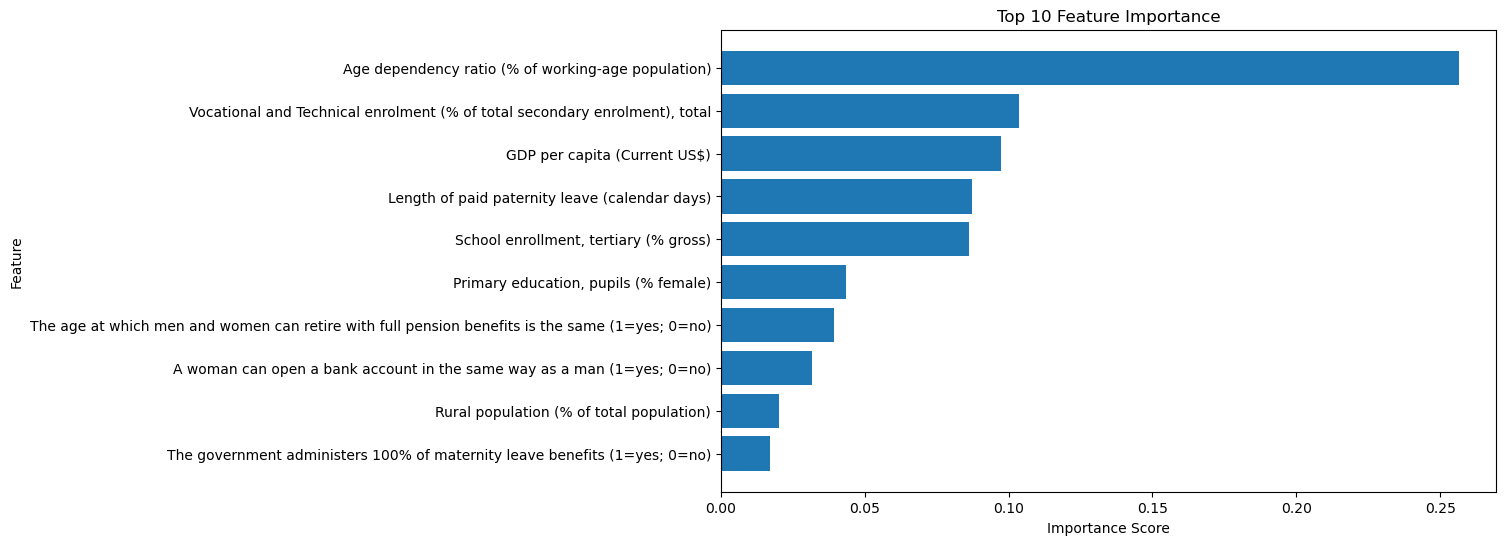

In [157]:
# obtain the feature importance
feature_importance = xgboost_finetuned.feature_importances_

# sort feature importance in descending order and pick the top 10
sorted_indices = feature_importance.argsort()[::-1] 
top_10_indices = sorted_indices[:10]

#plot the top 10 importances
plt.figure(figsize=(10, 6))
plt.barh(range(10, 0, -1), feature_importance[top_10_indices[::-1]], tick_label=X_train.columns[top_10_indices[::-1]])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

#### Difference Between actual y values and predictions - residual calculation

In [158]:
#create a df out of the predictions
y_pred_test_df = pd.DataFrame(y_pred_test_xgb_finetuned, index=X_test.index, columns = ['School enrollment predictions'])
y_pred_test_df

,,School enrollment predictions
Country Name,Country Code,
Guyana,GUY,-0.249007
Cyprus,CYP,0.186015
Mongolia,MNG,0.059430
Namibia,NAM,-0.064534
Mexico,MEX,-1.093796
...,...,...
Australia,AUS,-0.053834
Seychelles,SYC,-0.919383
"Korea, Rep.",KOR,0.021073


In [159]:
#create a df with actual and predicted secondary school female enrollment by country
dif_df = pd.concat([y_test['School enrollment, secondary, female (% gross)'], y_pred_test_df['School enrollment predictions']], axis=1, keys=['actual', 'prediction'])
#calculate the residual
dif_df['residual'] = dif_df['actual'] - dif_df['prediction']
#show the df
dif_df

,,actual,prediction,residual
Country Name,Country Code,,,
Guyana,GUY,0.004843,-0.249007,0.253850
Cyprus,CYP,0.115674,0.186015,-0.070341
Mongolia,MNG,0.000000,0.059430,-0.059430
Namibia,NAM,0.000000,-0.064534,0.064534
Mexico,MEX,-1.464595,-1.093796,-0.370799
...,...,...,...,...
Australia,AUS,0.000000,-0.053834,0.053834
Seychelles,SYC,-1.331799,-0.919383,-0.412415
"Korea, Rep.",KOR,0.008743,0.021073,-0.012329


#### Making the plot

In [160]:
import geopandas as gpd

world = gpd.read_file('ne_110m_admin_0_countries');
world = gpd.GeoDataFrame(world)

world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [163]:
print(world.columns)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


In [162]:
import plotly.express as px

# Merge 'world' dataframe on country names
merged = world.set_index('').join(dif_df).set_index('Country Code')

#color scale
colorscales = [
    [0.0, '#FFF3EB'],
    [0.5, '#F6BDB4'],
    [1.0, '#9D6449']
]


# Create a choropleth map
fig = px.choropleth(merged,
                    geojson=merged.geometry.__geo_interface__,
                    locations=merged.index, 
                    color='residual', 
                    color_continuous_scale=colorscales
                   )

# Update layout settings of the map
fig.update_layout(
    margin={"r":0, "t":0, "l":0, "b":0},
    coloraxis_colorbar={
        'title': "Residuals", 
        'orientation': "v",
        'len': 0.5 
    },
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)' ,
    title="Residuals by Country: School enrollment, secondary, female (% gross)"   
)

# Display the figure
fig.show()

KeyError: "None of [''] are in the columns"

### References

1. Lab 3 Solutions
2. Lab 6 Solutions
3. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
6. Lab 8 Solutions
7. https://www.datacamp.com/tutorial/xgboost-in-python
8. https://machinelearningmastery.com/xgboost-for-regression/
9. https://stackoverflow.com/questions/21231834/creating-a-pandas-dataframe-from-columns-of-other-dataframes-with-similar-indexe